# Hypothesis Testing

In [1]:
import warnings
import tqdm
import torch
import confounding_robust_inference as cri

from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

/tmp/ipykernel_82724/2912862134.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
beta = torch.as_tensor([1, 0.5, -0.5, 0, 0], dtype=TORCH_DTYPE)
policy = cri.policies.LogisticPolicy(beta)
data = cri.data.SyntheticDataBinary()
Y, T, X, _, p_t, _ = data.sample(4000)

In [3]:
ipw = cri.estimators.IPWEstimator().fit(Y, T, X, p_t, policy).predict()
true_ipw = data.evaluate_policy(policy, n_mc=100000000)
true_lower_bound = data.evaluate_policy_lower_bound(policy, Gamma=1.5, n_mc=100000000)
bias = ipw - true_ipw

## Confidence intervals with first order asymptotics

In [4]:
def get_lower_bound_ci(Gamma):
    estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=30)
    estimator.fit(Y, T, X, p_t, policy)
    return estimator.predict_ci()


def get_upper_bound_ci(Gamma):
    estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=30)
    estimator.fit(-Y, T, X, p_t, policy)
    low, high = estimator.predict_ci()
    return -high, -low

In [5]:
Gammas = [1 + i / 10 for i in range(11)]
lower_bound_cis = [get_lower_bound_ci(Gamma) for Gamma in Gammas]
upper_bound_cis = [get_upper_bound_ci(Gamma) for Gamma in Gammas]

In [6]:
lower_bounds = [(l + h) / 2 for (l, h) in lower_bound_cis]
upper_bounds = [(l + h) / 2 for (l, h) in upper_bound_cis]
lower_bound_cis_high = [h for (l, h) in lower_bound_cis]
upper_bound_cis_high = [h for (l, h) in upper_bound_cis]
lower_bound_cis_low = [l for (l, h) in lower_bound_cis]
upper_bound_cis_low = [l for (l, h) in upper_bound_cis]

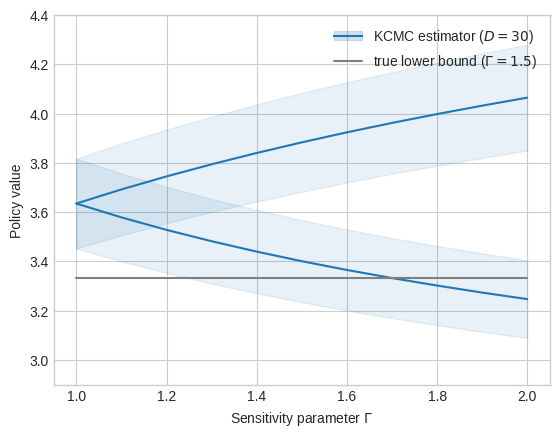

In [7]:
lower_line = plt.plot(Gammas, lower_bounds, color=tab10(0))[0]
upper_line = plt.plot(Gammas, upper_bounds, color=tab10(0))[0]
lower_band = plt.fill_between(
    Gammas, lower_bound_cis_low, lower_bound_cis_high, color=tab10(0), alpha=0.1
)
upper_band = plt.fill_between(
    Gammas, upper_bound_cis_low, upper_bound_cis_high, color=tab10(0), alpha=0.1
)
true_line = plt.plot(Gammas, [true_lower_bound] * 11, c=tab10(7))[0]
plt.ylim([2.9, 4.4])
plt.legend(
    [(lower_line, upper_line, lower_band, upper_band), (true_line,)],
    ["KCMC estimator ($D=30$)", "true lower bound ($\Gamma=1.5$)"],
)
plt.xlabel(r"Sensitivity parameter $\Gamma$")
plt.ylabel(r"Policy value")
plt.savefig("fig/hypothesis_testing_first_order.pdf")

## Confidence intervals with second order asymptotics

In [8]:
def get_lower_bound_and_ci(Gamma):
    estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=30)
    estimator.fit(Y, T, X, p_t, policy)
    mid = estimator.predict()
    low, high = estimator.predict_ci(consider_second_order=Gamma != 1.0)
    return low, mid, high


def get_upper_bound_and_ci(Gamma):
    estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=30)
    estimator.fit(-Y, T, X, p_t, policy)
    mid = estimator.predict()
    low, high = estimator.predict_ci(consider_second_order=Gamma != 1.0)
    return -high, -mid, -low

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # just to ignore warnings on asymptotics
    Gammas = [1 + i / 10 for i in range(11)]
    lower_bound_and_cis = [get_lower_bound_and_ci(Gamma) for Gamma in Gammas]
    upper_bound_and_cis = [get_upper_bound_and_ci(Gamma) for Gamma in Gammas]

In [10]:
lower_bounds = [m for (l, m, h) in lower_bound_and_cis]
upper_bounds = [m for (l, m, h) in upper_bound_and_cis]
lower_bound_cis_high = [h for (l, m, h) in lower_bound_and_cis]
upper_bound_cis_high = [h for (l, m, h) in upper_bound_and_cis]
lower_bound_cis_low = [l for (l, m, h) in lower_bound_and_cis]
upper_bound_cis_low = [l for (l, m, h) in upper_bound_and_cis]

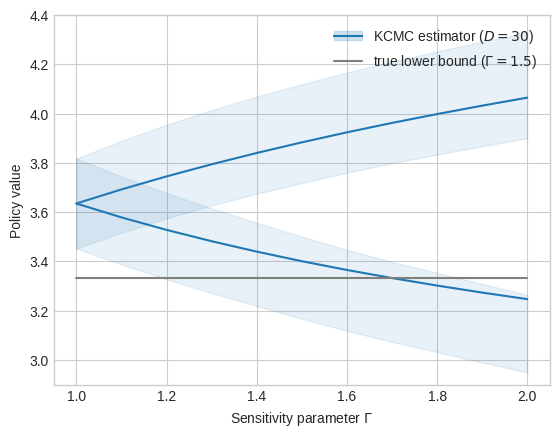

In [11]:
lower_line = plt.plot(Gammas, lower_bounds, color=tab10(0))[0]
upper_line = plt.plot(Gammas, upper_bounds, color=tab10(0))[0]
lower_band = plt.fill_between(
    Gammas, lower_bound_cis_low, lower_bound_cis_high, color=tab10(0), alpha=0.1
)
upper_band = plt.fill_between(
    Gammas, upper_bound_cis_low, upper_bound_cis_high, color=tab10(0), alpha=0.1
)
true_line = plt.plot(Gammas, [true_lower_bound] * 11, c=tab10(7))[0]

plt.ylim([2.9, 4.4])
plt.legend(
    [(lower_line, upper_line, lower_band, upper_band), (true_line,)],
    ["KCMC estimator ($D=30$)", "true lower bound ($\Gamma=1.5$)"],
)
plt.xlabel(r"Sensitivity parameter $\Gamma$")
plt.ylabel(r"Policy value")
plt.savefig("fig/hypothesis_testing_second_order.pdf")

## Acceptance Rate of Null Hypothesis using tests using first ans second order asymptotics

In [12]:
from dataclasses import dataclass


@dataclass
class CI:
    low: float
    high: float


def generate_ci(seed):
    # setup toy policy and data
    _ = torch.random.manual_seed(seed)
    TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
    beta = torch.as_tensor([1, 0.5, -0.5, 0, 0], dtype=TORCH_DTYPE)
    policy = cri.policies.LogisticPolicy(beta)
    data = cri.data.SyntheticDataBinary()
    Y, T, X, _, p_t, _ = data.sample(2000)

    estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=1.5, D=30)
    estimator.fit(Y, T, X, p_t, policy)
    est = estimator.predict()
    low_first, high_first = estimator.predict_ci(consider_second_order=False)
    low_second, high_second = estimator.predict_ci(consider_second_order=True)
    return est, CI(low_first, high_first), CI(low_second, high_second)

In [13]:
n_sim = 2000

with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # just to ignore warnings on asymptotics
    lower_bound_and_cis = [generate_ci(seed) for seed in tqdm.tqdm(range(n_sim))]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:54:03<00:00,  3.42s/it]


In [14]:
mesh = torch.linspace(2.5, 4, 1001)
mesh_in_ci_first = torch.concat(
    [
        torch.logical_and(cis[1].low <= mesh, mesh <= cis[1].high)[None]
        for cis in lower_bound_and_cis
    ],
    axis=0,
)
mesh_in_ci_second = torch.concat(
    [
        torch.logical_and(cis[2].low <= mesh, mesh <= cis[2].high)[None]
        for cis in lower_bound_and_cis
    ],
    axis=0,
)
acceptance_rate_first = mesh_in_ci_first.type(torch.float).mean(axis=0)
acceptance_rate_second = mesh_in_ci_second.type(torch.float).mean(axis=0)

In [15]:
jitter = 0.01


def lower_band(probs):
    probs = torch.clip(probs, jitter, 1 - jitter)
    return probs - (probs * (1 - probs) / n_sim) ** 0.5


def upper_band(probs):
    probs = torch.clip(probs, jitter, 1 - jitter)
    return probs + (probs * (1 - probs) / n_sim) ** 0.5

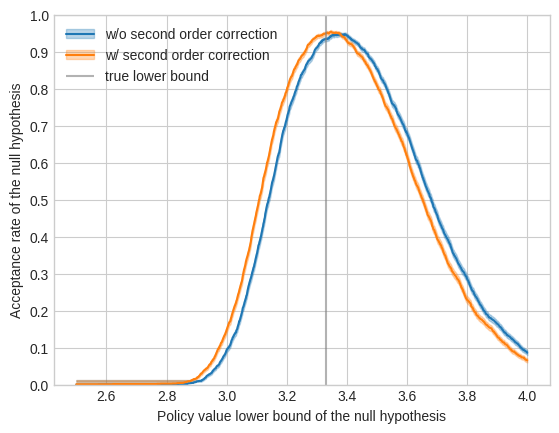

In [20]:
line_first = plt.plot(mesh, acceptance_rate_first, color=tab10(0))[0]
line_second = plt.plot(mesh, acceptance_rate_second, color=tab10(1))[0]
band_first = plt.fill_between(
    mesh,
    lower_band(acceptance_rate_first),
    upper_band(acceptance_rate_first),
    color=tab10(0),
    alpha=0.3,
)
band_second = plt.fill_between(
    mesh,
    lower_band(acceptance_rate_second),
    upper_band(acceptance_rate_second),
    color=tab10(1),
    alpha=0.3,
)
true_line = plt.vlines(true_lower_bound, 0, 1, color=tab10(7), alpha=0.6)
plt.legend(
    [(line_first, band_first), (line_second, band_second), (true_line,)],
    ["w/o second order correction", "w/ second order correction", "true lower bound"],
)
plt.ylim([0, 1])
plt.yticks([i / 10 for i in range(11)])
plt.xlabel("Policy value lower bound of the null hypothesis")
plt.ylabel("Acceptance rate of the null hypothesis")
plt.savefig("fig/hypothesis_testing_acceptance_rate.pdf")

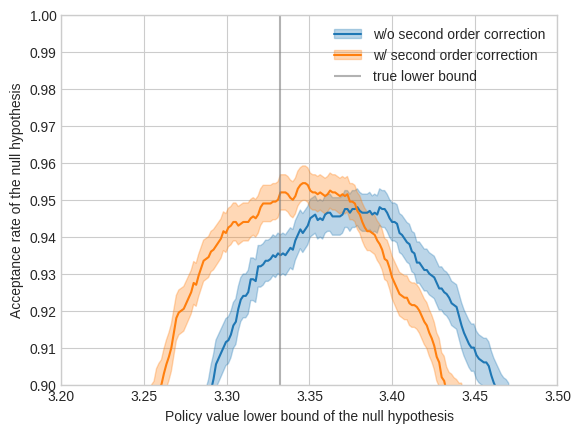

In [19]:
line_first = plt.plot(mesh, acceptance_rate_first, color=tab10(0))[0]
line_second = plt.plot(mesh, acceptance_rate_second, color=tab10(1))[0]
band_first = plt.fill_between(
    mesh,
    lower_band(acceptance_rate_first),
    upper_band(acceptance_rate_first),
    color=tab10(0),
    alpha=0.3,
)
band_second = plt.fill_between(
    mesh,
    lower_band(acceptance_rate_second),
    upper_band(acceptance_rate_second),
    color=tab10(1),
    alpha=0.3,
)
true_line = plt.vlines(true_lower_bound, 0, 1, color=tab10(7), alpha=0.6)
plt.legend(
    [(line_first, band_first), (line_second, band_second), (true_line,)],
    ["w/o second order correction", "w/ second order correction", "true lower bound"],
)
plt.ylim([0.9, 1])
plt.xlim([3.2, 3.5])
plt.yticks([i / 100 + 0.9 for i in range(11)])
plt.xlabel("Policy value lower bound of the null hypothesis")
plt.ylabel("Acceptance rate of the null hypothesis")
plt.savefig("fig/hypothesis_testing_acceptance_rate_zoomed.pdf")